In [156]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import to_categorical 
from matplotlib import pyplot as plt 
from progressbar import ProgressBar
pbar =  ProgressBar()

In [157]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [211]:
x_train_flat =  np.asarray([np.reshape(x, (28*28*1))/255 for x in x_train])
x_test_flat =  np.asarray([np.reshape(x, (28*28*1))/255 for x in x_test])
#print(x_train_flat[0])

In [212]:
one_hot_y_train =  to_categorical(y_train)
one_hot_y_test =  to_categorical(y_test)

In [271]:
np.random.seed(903378735)
def model_gen(shape , input_len):

    inputs =  keras.Input(shape=(input_len,))
    dense =  layers.Dense(22*22, activation='relu')
    x = dense(inputs)
    x =  layers.BatchNormalization(axis=-1)(x)
    #x = layers.Dropout(0.3)(x)
    for s in shape:
        x = layers.Dense(s, activation='relu')(x)
    x =  layers.BatchNormalization(axis=-1)(x)
    outputs = layers.Dense(10 , activation='softmax')(x)
    model = keras.Model(inputs=inputs , outputs=outputs , name='trial_model')
    np.random.seed(903378735)
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"],
    )
    return model
model = model_gen([64 , 36 , 16] , x_train_flat.shape[1])
history = model.fit(x_train_flat, one_hot_y_train, batch_size=64, epochs=10, validation_split=0.2 , verbose=1)
#pd.DataFrame(history.history).plot(figsize=(8,5))


Epoch 1/10
750/750 [==============================] - 6s 7ms/step - loss: 0.2935 - accuracy: 0.9262 - val_loss: 0.1350 - val_accuracy: 0.9588
Epoch 2/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1043 - accuracy: 0.9694 - val_loss: 0.1094 - val_accuracy: 0.9680
Epoch 3/10
750/750 [==============================] - 5s 7ms/step - loss: 0.0722 - accuracy: 0.9781 - val_loss: 0.1004 - val_accuracy: 0.9688
Epoch 4/10
750/750 [==============================] - 4s 6ms/step - loss: 0.0591 - accuracy: 0.9814 - val_loss: 0.0871 - val_accuracy: 0.9747
Epoch 5/10
750/750 [==============================] - 4s 6ms/step - loss: 0.0519 - accuracy: 0.9836 - val_loss: 0.0868 - val_accuracy: 0.9736
Epoch 6/10
750/750 [==============================] - 4s 5ms/step - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0908 - val_accuracy: 0.9751
Epoch 7/10
750/750 [==============================] - 4s 5ms/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.1006 - val_accuracy: 0.9720
Epoch 

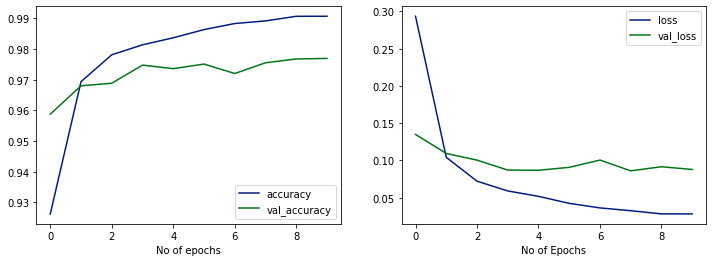

In [272]:
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'] , label = 'accuracy')
plt.plot(hist['val_accuracy'] , label = 'val_accuracy')
plt.xlabel('No of epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['loss'] , label = 'loss')
plt.plot(hist['val_loss'] , label='val_loss')
plt.xlabel("No of Epochs")
plt.legend()
#plt.savefig('plots/bn_model_level_0_rows.png')
plt.show()

In [197]:

def conf_mat(model , x , y ):
    '''
    parameters :
        model , x ,y 
    y not as one-hot-encoded
    returns confusion matrix
    '''
    
    oh_y_true = to_categorical(y)
    y_pred =  model.predict(x)
    oh_y_pred = np.zeros_like(y_pred)
    oh_y_pred[np.arange(len(y_pred)),y_pred.argmax(1)] = 1
    #print(oh_y_pred.shape)
    #print(oh_y_true.shape)
    mat =  np.matmul(oh_y_true.T , oh_y_pred)
    return mat


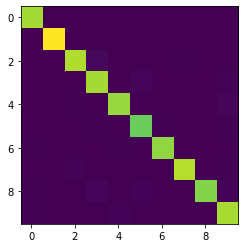

In [198]:
conf_matrix = conf_mat(model , x_test_flat , y_test)
plt.imshow(conf_matrix)

In [199]:

from matplotlib import pyplot as plt
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(0, 220, n=n_colors) # Create the palette
plt.style.use('seaborn-dark-palette')

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    #print(ind , len(palette))
    #print('---------------------------------')
    return palette[ind]

def heatmap(x,y,size):
    fig , ax = plt.subplots(figsize=(6,6))

    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0]for p in enumerate(x_labels)}
    #display(x_to_num)
    y_to_num = {p[1]:p[0]for p in enumerate(y_labels)}

    color = [value_to_color(c) for c in size]
    size_scale = 1 
    ax.scatter(
        x = x.map(x_to_num),
        y = y.map(y_to_num),
        s = size * size_scale,
        marker = 's',
        
        c = color
    )

    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45 , horizontalalignment='right')

    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    #plt.savefig('plots/top_corr_30_lmxb.jpg')
    return (fig, ax)


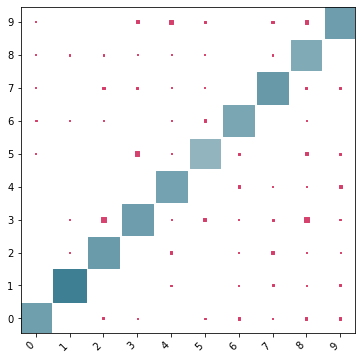

In [273]:
corr = pd.DataFrame(conf_matrix)
corr = pd.melt(corr.reset_index() , id_vars='index')
corr.columns = ['x','y' ,'value']
# Range of values that will be mapped to the palette, i.e. min and max possible correlation
color_min, color_max = [np.amin(corr['value']), np.amax(corr['value'])]
fig , ax = heatmap(
    x=corr['x'], 
    y=corr['y'],
    size = corr['value'].abs())
plt.show()


0.9999999 0.9921568627450981
(10000,)
(10000,)
[3.9136705e-05]


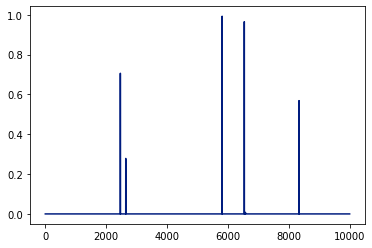

In [274]:
y_pred = model.predict(x_test_flat)
f = 45
v1 = y_pred[:,0]
v2 =  x_test_flat[:,f]
print(np.amax(v1) , np.amax(v2))
print(v1.shape)
print(v2.shape)
print(np.correlate(v1 , v2 , mode='valid'))
#plt.plot(v1)
plt.plot(v2)

In [275]:
v1 = y_pred.T[1]
print(cl.shape)
c = np.asarray([[correlate(v1,v2 , mode='valid')[0] for v2 in x_test_flat.T] for v1 in y_pred.T]) 
print(c.shape)

(10000,)
(10, 784)


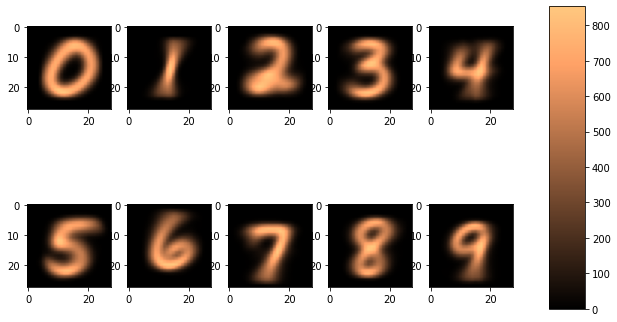

In [276]:

fig, axes = plt.subplots(nrows=2, ncols=5 , figsize=(10,6))
i = 0
for ax in axes.flat:
    im = ax.imshow(np.reshape(c[i] , (28,28)) , cmap='copper')
    i+=1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()


In [277]:
extractor = keras.Model(
    inputs=model.inputs,
    outputs=[layer.output for layer in model.layers])

In [278]:

print(y_pred_1.shape)

(10000, 8)


(10000, 784)
(10000,)
(10, 784)


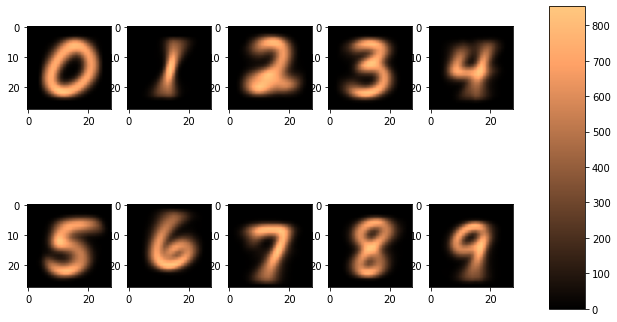

In [279]:
y_pred =  model.predict(x_test_flat)
activation = extractor.predict(x_test_flat)[0]
print(activation.shape)

v1 = y_pred.T[1]
print(cl.shape)
c = np.asarray([[correlate(v1,v2 , mode='valid')[0] for v2 in activation.T] for v1 in y_pred.T]) 
print(c.shape)


fig, axes = plt.subplots(nrows=2, ncols=5 , figsize=(10,6))
i = 0
for ax in axes.flat:
    im = ax.imshow(np.reshape(c[i] , (28,28)) , cmap='copper')
    i+=1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()



(10000, 16)
(10000,)
(10, 16)


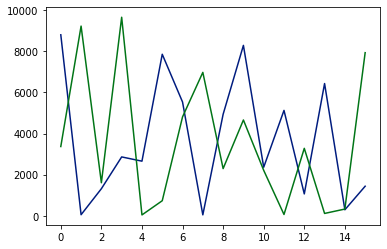

In [280]:
y_pred =  model.predict(x_test_flat)
activation = extractor.predict(x_test_flat)[5]
print(activation.shape)

v1 = y_pred.T[1]
print(cl.shape)
c = np.asarray([[correlate(v1,v2 , mode='valid')[0] for v2 in activation.T] for v1 in y_pred.T]) 
print(c.shape)

for ci in c[:2]:
    plt.plot(ci)
#plt.plot(c[0])
#plt.plot(c[1])
plt.show()

In [281]:
print(activation[0])
print(y_pred[0])

[ 0.         8.470142   5.288478   1.156582   1.8217369  6.8556185
  0.         0.5279742  0.         7.9633102  1.4031615  0.
  4.5224304  4.7180676 10.102589   6.960951 ]
[1.6958955e-05 8.2427323e-06 5.5329060e-06 1.1585613e-05 1.1076555e-05
 2.1212749e-05 1.1519932e-06 9.9933547e-01 3.6201709e-07 5.8850570e-04]


In [282]:
def nodes_imp(model , x_test_flat):
    y_pred =  model.predict(x_test_flat)
    activation = extractor.predict(x_test_flat)
    #print(activation.shape)
    imp = []
    for act in activation:
        v1 = y_pred.T[1]
    #print(cl.shape)
        c = np.asarray([[correlate(v1,v2 , mode='valid')[0] for v2 in act.T] for v1 in y_pred.T]) 
    #print(c.shape)
        imp.append(c)
    return imp
imp =  nodes_imp(model, x_test_flat)

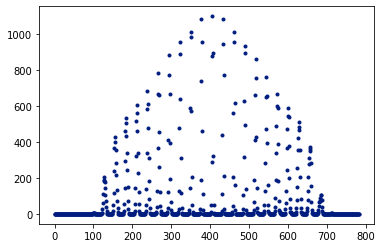

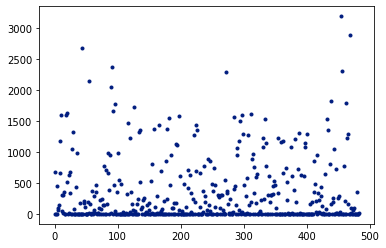

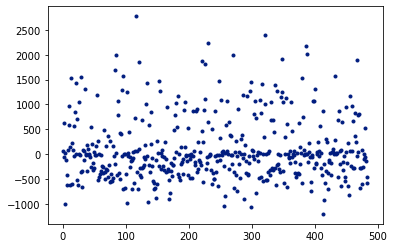

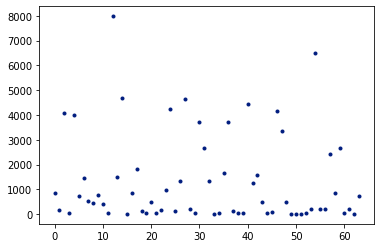

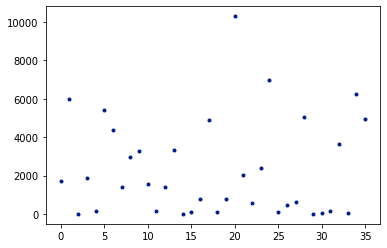

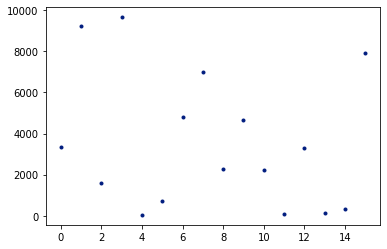

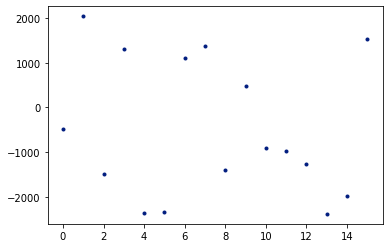

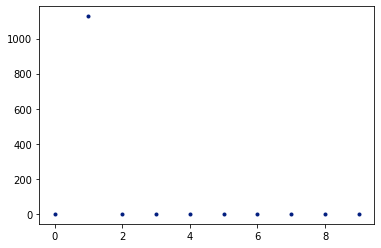

In [284]:
for i in imp:
    plt.plot(i[1].T , '.')
    plt.show()

In [263]:
print(imp[0].shape)

(10, 784)
